# 🎨 Visualize Inference Samples

Quick verification - run inference on sample images to verify models work correctly on real-world imagery.

**Run this FIRST before full inference!**

## What This Does:
- Loads trained YOLO models
- Runs inference on 6 sample images
- Saves annotated images with bounding boxes
- Shows detection counts

## Expected Output:
- `results/inference_samples/*.jpg` - Annotated images

In [2]:
import os
from pathlib import Path
from ultralytics import YOLO
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful")

✅ Imports successful


## Configuration

In [4]:
# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
RAW_SATELLITE = DATA_DIR / "raw" / "satellite"
MODELS_DIR = DATA_DIR / "models" / "satellite"
OUTPUT_DIR = PROJECT_ROOT / "results" / "inference_samples"

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Models
MODELS = {
    'retail': MODELS_DIR / "retail_yolo11_20251126_150811" / "weights" / "best.pt",
    'ports': MODELS_DIR / "ports_dota_yolo11_20251127_013205" / "weights" / "best.pt",
}

# Sample locations to visualize (UPDATED - USING AVAILABLE IMAGES)
SAMPLES = {
    'retail': [
        ('Bluewater', 2017, 'sentinel-2-l2a'),
        ('Galeries_Lafayette', 2017, 'sentinel-2-l2a'),
        ('Centro_Oberhausen', 2018, 'sentinel-2-l2a'),
    ],
    'ports': [
        ('Port_of_Antwerp', 2017, 'sentinel-2-l2a'),
    ],
}

print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"📊 Models to test: {list(MODELS.keys())}")
print(f"🖼️  Total samples: {sum(len(v) for v in SAMPLES.values())}")

📁 Output directory: D:\MS\UMD\Courses\Fall-2025\DATA-650\Real-Time-Economic-Forecasting\results\inference_samples
📊 Models to test: ['retail', 'ports']
🖼️  Total samples: 4


## Helper Functions

In [6]:
def find_image(location: str, year: int, dataset: str) -> Path:
    """Find image file."""
    if dataset == 'naip':
        path = RAW_SATELLITE / "naip" / str(year) / f"{location}_naip_{year}.tif"
    else:
        path = RAW_SATELLITE / dataset / str(year) / f"{location}_{dataset}_{year}.tif"
    
    return path if path.exists() else None


def load_tif_as_rgb(image_path: Path) -> np.ndarray:
    """Load multi-band TIF and convert to RGB for YOLO."""
    with rasterio.open(image_path) as src:
        # Read first 3 bands (or RGB bands if available)
        if src.count >= 3:
            r = src.read(1)
            g = src.read(2)
            b = src.read(3)
        else:
            # Grayscale - duplicate to 3 channels
            band = src.read(1)
            r = g = b = band
        
        # Stack to RGB
        rgb = np.dstack([r, g, b])
        
        # Normalize to 0-255 if needed
        if rgb.max() > 255:
            rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype(np.uint8)
        else:
            rgb = rgb.astype(np.uint8)
        
        return rgb


def run_inference_and_save(
    model_path: Path,
    image_path: Path,
    output_path: Path,
    activity_type: str
):
    """Run inference and save annotated image."""
    # Load model
    model = YOLO(str(model_path))
    
    # Load image properly (handle multi-band TIF)
    if image_path.suffix.lower() in ['.tif', '.tiff']:
        img = load_tif_as_rgb(image_path)
    else:
        img = cv2.imread(str(image_path))
    
    if img is None or img.size == 0:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # Run inference
    results = model(
        img,
        conf=0.25,
        iou=0.45,
        imgsz=640,
        device=0,
        verbose=False
    )[0]
    
    # Get annotated image
    annotated = results.plot()
    
    # Save
    cv2.imwrite(str(output_path), annotated)
    
    # Print detection count
    num_detections = len(results.boxes)
    print(f"   ✅ {image_path.stem}: {num_detections} objects detected")
    
    return num_detections, annotated

print("✅ Helper functions defined")

✅ Helper functions defined


## Run Inference on Samples

In [8]:
print("\n" + "="*80)
print("🎨 VISUALIZING INFERENCE SAMPLES")
print("="*80)

total_visualized = 0
visualizations = {}  # Store for display

for activity_type, samples in SAMPLES.items():
    model_path = MODELS.get(activity_type)
    
    if not model_path or not model_path.exists():
        print(f"\n⚠️  {activity_type.upper()} model not found, skipping")
        continue
    
    print(f"\n{'='*80}")
    print(f"📸 {activity_type.upper()} Samples")
    print(f"{'='*80}")
    
    visualizations[activity_type] = []
    
    for location, year, dataset in samples:
        # Find image
        image_path = find_image(location, year, dataset)
        
        if not image_path:
            print(f"   ⚠️  {location} ({year}): Image not found")
            continue
        
        # Output path
        output_filename = f"{activity_type}_{location}_{year}.jpg"
        output_path = OUTPUT_DIR / output_filename
        
        # Run inference and save
        try:
            num_detections, annotated = run_inference_and_save(
                model_path, image_path, output_path, activity_type
            )
            visualizations[activity_type].append({
                'location': location,
                'year': year,
                'detections': num_detections,
                'image': annotated
            })
            total_visualized += 1
        except Exception as e:
            print(f"   ❌ {location}: Error - {e}")

print("\n" + "="*80)
print(f"✅ Complete! {total_visualized} visualizations saved")
print(f"📁 Check: {OUTPUT_DIR}")
print("="*80)


🎨 VISUALIZING INFERENCE SAMPLES

📸 RETAIL Samples
   ✅ Bluewater_sentinel-2-l2a_2017: 0 objects detected
   ✅ Galeries_Lafayette_sentinel-2-l2a_2017: 0 objects detected
   ✅ Centro_Oberhausen_sentinel-2-l2a_2018: 0 objects detected

📸 PORTS Samples
   ✅ Port_of_Antwerp_sentinel-2-l2a_2017: 1 objects detected

✅ Complete! 4 visualizations saved
📁 Check: D:\MS\UMD\Courses\Fall-2025\DATA-650\Real-Time-Economic-Forecasting\results\inference_samples


## Display Sample Results

View some of the inference results directly in the notebook:


🛒 RETAIL SAMPLES:


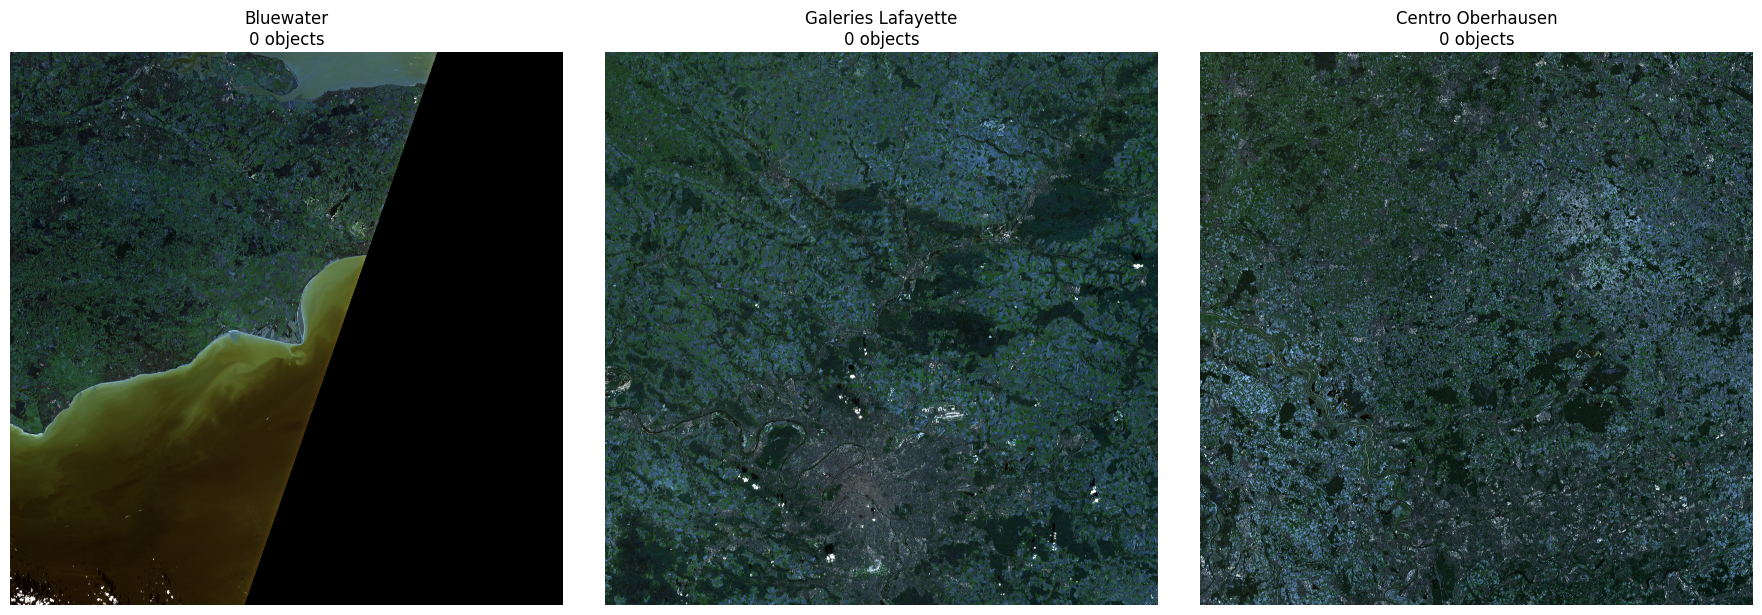

In [10]:
# Display retail samples
if 'retail' in visualizations and visualizations['retail']:
    print("\n🛒 RETAIL SAMPLES:")
    fig, axes = plt.subplots(1, min(3, len(visualizations['retail'])), figsize=(18, 6))
    if len(visualizations['retail']) == 1:
        axes = [axes]
    
    for idx, (ax, sample) in enumerate(zip(axes, visualizations['retail'])):
        # Convert BGR to RGB for display
        img_rgb = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f"{sample['location'].replace('_', ' ')}\n{sample['detections']} objects")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


🚢 PORT SAMPLES:


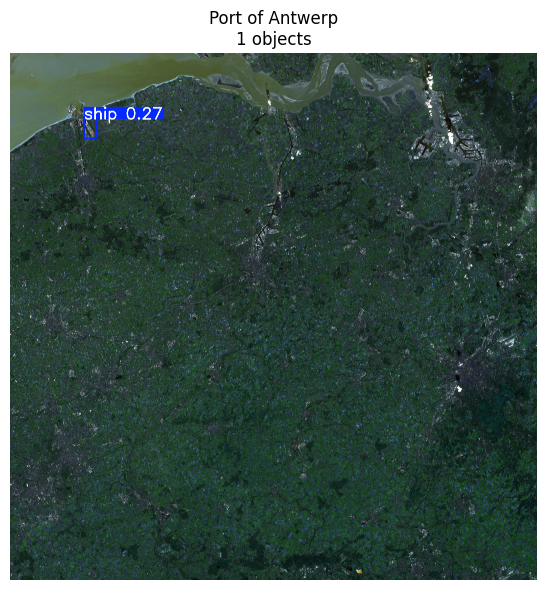

In [11]:
# Display port samples
if 'ports' in visualizations and visualizations['ports']:
    print("\n🚢 PORT SAMPLES:")
    fig, axes = plt.subplots(1, min(3, len(visualizations['ports'])), figsize=(18, 6))
    if len(visualizations['ports']) == 1:
        axes = [axes]
    
    for idx, (ax, sample) in enumerate(zip(axes, visualizations['ports'])):
        # Convert BGR to RGB for display
        img_rgb = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f"{sample['location'].replace('_', ' ')}\n{sample['detections']} objects")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Summary

Review the annotated images in the `results/inference_samples/` directory.

**If detections look good, proceed to run the full inference pipeline!**

Next: `Inference_Satellite_Activity.ipynb`